In [32]:
# Cài thư viên lấy thông tin về tên miền từ dịch vụ whois.
!pip install python-whois
# Cài thư viện phân tích các thành phần của một tên miền, bao gồm phần tên miền
# cấp cao nhất (TLD), tên miền chính (domain), và tên miền con (subdomain).
!pip install tldextract

In [33]:
import pandas as pd
import numpy as np
import sys
import re
from urllib.parse import urlparse, urlencode
from datetime import datetime
import ipaddress
import whois
import urllib
import urllib.request
import tldextract
import pickle

class FeatureExtract:

    def __init__(self):
      pass

    def rank(self, url):
        try:
            # Filling the whitespaces in the URL if any
            url = urllib.parse.quote(url)

            # Make a request to SimilarWeb API
            response = requests.get(f"https://api.similarweb.com/v1/website/{url}/global-rank/global-list?api_key={api_key}")
            data = response.json()

            # Extract global rank from the response
            global_rank = data.get('GlobalRank', {}).get('Rank', None)

            # Check if the global rank is available and less than 100000
            if global_rank is not None and global_rank < 100000:
                return 0  # Rank is less than 100000
            else:
                return 1  # Rank is equal to or greater than 100000

        except Exception as e:
            print(f"Error: {e}")
            return 1  # Return 1 for any errors

    # Phương thức kiểm tra xem có địa chỉ IP tồn tại trong URL không.
    # Nếu có trả về 1 (lừa đảo), không có trả về 0 (hợp pháp).
    def isIP(self,url):
      try:
        ipaddress.ip_address(url)
        ip = 1
      except:
        ip = 0
      return ip

    # Phương thức kiểm tra tính hợp lệ của URL.
    # Nếu tuổi của tên miền < 6 tháng, trả về 1 (lừa đảo), ngược lại trả về 0 (hợp pháp).
    def isValid(self,domain_name):
      creation_date = domain_name.creation_date
      expiration_date = domain_name.expiration_date
      if (isinstance(creation_date,str) or isinstance(expiration_date,str)):
        try:
          creation_date = datetime.strptime(creation_date,'%Y-%m-%d')
          expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
        except:
          return 1
      if ((expiration_date is None) or (creation_date is None)):
        return 1
      elif ((type(expiration_date) is list) or (type(creation_date) is list)):
        return 1
      else:
        ageofdomain = abs((expiration_date - creation_date).days)
        if ((ageofdomain/30) < 6):
          age = 1
        else:
          age = 0
      return age

    # Kiểm tra xem URL đã hết hạn hay chưa.
    # Nếu tên miền đã hết hạn, trả về 1 (lừa đảo), ngược lại trả về 0 (hợp pháp)
    def domain_reg_len(self,domain_name):
      print('hello')
      expiration_date = domain_name.expiration_date
      if isinstance(expiration_date,str):
        try:
          expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
        except:
          return 1
      if (expiration_date is None):
        return 1
      elif (type(expiration_date) is list):
        return 1
      else:
        today = datetime.now()
        end = abs((expiration_date - today).days)
        if ((end/30) < 6):
          end = 0
        else:
          end = 1
      return end

    # Kiểm tra xem URL có chứa '@' hay không.
    # Nếu có '@' trả về 1 (lừa đảo), ngược lại trả về 0 (hợp pháp)
    def isat(self,url):
      if "@" in url:
        return 1
      else:
        return 0

    # Kiểm tra xem URL có chứa '//' liền kề
    # trong ngữ cảnh của 'http://' hoặc 'https://' không (chuyển hướng)
    # Nếu có trả về 1 (lừa đảo), ngược lại trả về 0 (hợp pháp)
    def isRedirect(self,url):
      pos = url.rfind('//')
      if pos > 6:
        if pos > 7:
          return 1
        else:
          return 0
      else:
        return 0

    # Kiểm tra xem có chứa '-' trong phần netloc của URL không.
    # Nếu có trả vê 1 (lừa đảo), nếu không trả về 0 (hợp pháp).
    def haveDash(self,url):
        if '-' in urlparse(url).netloc:
            return 1
        else:
            return 0

    # Kiếm tra xem URL có chưa nhiều hơn một tên miền phụ hay không.
    # Nếu số lượng tên miền là 1, trả về 0 (hợp pháp), ngược lại trả về 1 (lừa đảo)
    def no_sub_domain(self,url):
      url = str(url)
      url = url.replace("www.","")
      url = url.replace("."+tldextract.extract(url).suffix,"")
      count = url.count(".")
      if count==1:
        return 0
      else:
        return 1

    # Kiểm tra xem có chứa 'http' trong phần netloc của URL hay không.
    # Nếu có trả về 1 (lừa đảo), nếu không trả về 0 (hợp pháp)
    def httpDomain(self,url):
      domain = urlparse(url).netloc
      if 'http' in domain:
        return 1
      else:
        return 0

    # Kiểm tra độ dài của URL.
    # Nếu độ dài < 54 kí tự , trả về 0 (hợp pháp), ngược lại trả về 1 (lừa đảo)
    def LongURL(self,url):
      if len(url) < 54:
        return 0
      else:
        return 1

    # Kiểm tra xem URL có thuộc về các dịch vụ rút gọn URL hay không.
    # Nếu có trả về 1 (lừa đảo), ngược lại trả về 0 (hợp pháp).
    def tinyURL(self,url):
        shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"
        match=re.search(shortening_services,url)
        if match:
            return 1
        else:
            return 0

class PredictURL(FeatureExtract):

    def __init__(self):
        pass

    # Dự đoán xem URL có phải là PHISHING hay LEGITIMATE.
    # Nhận vào một URL làm đối số.
    def predict(self,url):
        print("hi")
        feature = []
        dns = 0

        # URL được chuyển đến API whois để lấy tên miền.
        try:
            print("hi")
            domain_name = whois.whois(urlparse(url).netloc)
            print("hi2")
        except:
            dns = 1

        # Domain based features
        feature.append(self.rank(url))
        feature.append(1 if dns == 1 else self.isValid(domain_name))
        feature.append(1 if dns == 1 else self.domain_reg_len(domain_name))

        #Address bar based features
        feature.append(self.isIP(url))
        feature.append(self.isat(url))
        feature.append(self.isRedirect(url))
        feature.append(self.haveDash(url))
        feature.append(self.no_sub_domain(url))
        feature.append(self.LongURL(url))
        feature.append(self.tinyURL(url))

        return self.classify(np.array(feature).reshape((1,-1)))

    # Xác định những thuộc tính nào sẽ được lưu trữ trong file pickle.
    def __getstate__(self):
        state = self.__dict__.copy()
        return state

    # Khôi phục các thuộc tính  từ dữ liệu được lưu trữ trong file pickle.
    def __setstate__(self, state):
        self.__dict__.update(state)

    # Phân loại URL dựa trên các features.
    def classify(self,features):

        # Mở tệp pickle trong chế độ đọc nhị phân.
        # Tệp này chứa mô hình đã train để phân loại các đặc trưng của URL.
        pick_file = open('PHISHING_CLASSIFIER.pkl', 'rb')

        # Dùng thư viện pickle để tải mô hình.
        # Mô hình này đã được lưu trữ trước đó bằng quá trình pickling.
        Pickled_sample_Model = pickle.load(pick_file)
        # Đóng tệp pickle sau khi đã đọc mô hình để giải phóng tài nguyên.
        pick_file.close()

        # Dự đoán phân loại của URL dựa trên các đặc trưng.
        result = Pickled_sample_Model.predict(features)
        if result == 0:
            return "ĐÂY CÓ THỂ LÀ TRANG WEB HỢP PHÁP. (LEGITIMATE)"
        else:
            return "ĐÂY CÓ THỂ LÀ TRANG WEB LỪA ĐẢO. (PHISHING)"

def main():
    pass

if __name__ == "__main__":
    main()

In [34]:
!pip install whois
!pip install tldextract
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
from math import sqrt

In [35]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## ĐỌC FILE DATASET

In [36]:
phishing_raw_df = pd.read_csv("/content/drive/MyDrive/PHISHING/Dataset.csv", header = 0)

In [37]:
# Loại bỏ các dòng có giá trị NaN (thiếu dữ liệu).
phishing_raw_df = phishing_raw_df.dropna()
# Loại bỏ các dòng trùng lặp.
phishing_raw_df = phishing_raw_df.drop_duplicates()
# Đặt lại chỉ số của DataFrame sau khi xóa dòng hoặc cột.
phishing_raw_df = phishing_raw_df.reset_index(drop=True)
# In ra kích thước mới của DataFrame (hàng, cột)
phishing_raw_df.shape

(72363, 12)

In [38]:
print(phishing_raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72363 entries, 0 to 72362
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   domain          72363 non-null  object
 1   ranking         72363 non-null  int64 
 2   isIp            72363 non-null  int64 
 3   valid           72363 non-null  int64 
 4   activeDuration  72363 non-null  int64 
 5   urlLen          72363 non-null  int64 
 6   is@             72363 non-null  int64 
 7   isredirect      72363 non-null  int64 
 8   haveDash        72363 non-null  int64 
 9   domainLen       72363 non-null  int64 
 10  nosOfSubdomain  72363 non-null  int64 
 11  label           72363 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.6+ MB
None


## TIỀN XỬ LÝ DỮ LIỆU

Legitimate URL: 31025
Phishing URL: 41338
TỶ LỆ: 0.75 : 1


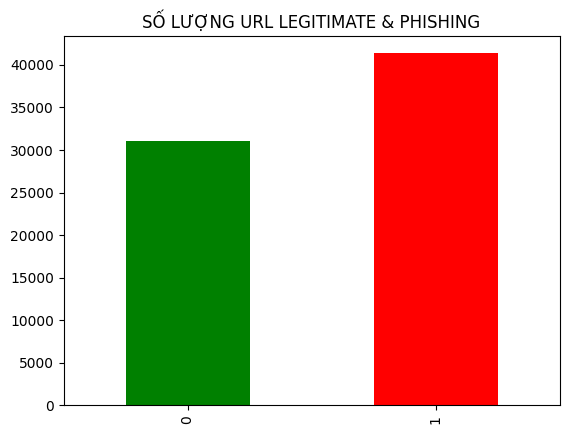

In [39]:
# Đếm số lượng các giá trị trong cột 'label' của DataFrame
# In ra số lượng URL thuộc lớp "Legitimate" và "Phishing".
target_count = phishing_raw_df.label.value_counts()
print('Legitimate URL:', target_count[0])
print('Phishing URL:', target_count[1])
# Tỷ lệ giữa số lượng URL "Legitimate" và "Phishing", được làm tròn đến 2 chữ số thập phân.
print('TỶ LỆ:', round(target_count[0] / target_count[1], 2), ': 1')
# Đảo ngược thứ tự các cột trong biểu đồ
reordered_counts = phishing_raw_df.label.value_counts().sort_index(ascending=True)
# Vẽ biểu đồ
reordered_counts.plot(kind='bar', color=['green', 'red'], title='SỐ LƯỢNG URL LEGITIMATE & PHISHING');

Random under-sampling:
1    31025
0    31025
Name: label, dtype: int64


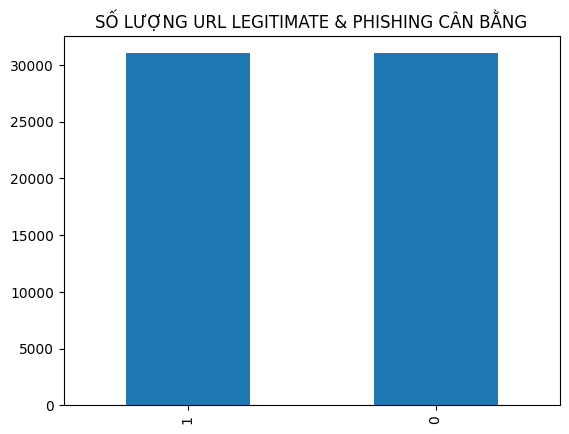

In [40]:
# Thực hiện 'undersampling' để xử lý mất cân bằng giữa 2 lớp trong tập dữ liệu.

# Đếm số lượng các mẫu trong mỗi lớp của tập dữ liệu.
count_class_1, count_class_0 = phishing_raw_df.label.value_counts()

# Tạo hai DataFrame mới chứa các mẫu tương ứng với lớp 0 và lớp 1 từ DataFrame gốc.
df_class_0 = phishing_raw_df[phishing_raw_df['label'] == 0]
df_class_1 = phishing_raw_df[phishing_raw_df['label'] == 1]

# Label 1 > 0
# Thực hiện undersampling trên lớp 1
# (Lấy ngẫu nhiên một số mẫu từ lớp 1 để giảm xuống cùng số mẫu lớp 0.
df_class_1_under = df_class_1.sample(count_class_0)
# Tạo ra một DataFrame mới với số lượng mẫu bằng nhau cho cả hai lớp.
phishing_raw_df = pd.concat([df_class_1_under, df_class_0], axis=0)

print('Random under-sampling:')
print(phishing_raw_df.label.value_counts())

phishing_raw_df.label.value_counts().plot(kind='bar', title='SỐ LƯỢNG URL LEGITIMATE & PHISHING CÂN BẰNG');

In [41]:
phishing_raw_df.head()

,domain,ranking,isIp,valid,activeDuration,urlLen,is@,isredirect,haveDash,domainLen,nosOfSubdomain,label
10291,www.pussystuffinggirls.com/account,10000000,0,0,0,34,0,0,0,26,2,1
46039,futureteck.net//stgeorge.htm,10000000,0,0,0,28,0,1,0,14,1,1
40799,www.westsideuu.org/signin.ebay.com/index.htm,10000000,0,1,6940,44,0,0,0,18,2,1
68654,agmp.kz/visa?key=73656C7472656368742E736368656...,10000000,0,0,0,71,0,0,0,7,1,1
43304,thecountrymoon.com/images/stories.php,10000000,0,1,366,37,0,0,0,18,1,1


## CHUYỂN ĐỔI DỮ LIỆU

In [42]:
# Object created for the features class imported from feature_extract file
# Gọi các phương thức của lớp FeatureExtract để trích xuất các đặc trưng từ URL.
feature = FeatureExtract()

In [43]:
# Tạo một cột mới có tên là "Domain_http".
# Giá trị được xác định bằng cách áp dụng hàm feature.httpDomain(x).
phishing_raw_df["Domain_http"] = phishing_raw_df["domain"].apply( lambda x: feature.httpDomain(x))

# Tạo một cột mới có tên là "LongURL" để chỉ độ dài của URL.
# Giá trị được xác định bằng cách áp dụng hàm feature.LongURL(x).
phishing_raw_df["LongURL"] = phishing_raw_df["domain"].apply( lambda x: feature.LongURL(x))

# Tạo một cột mới có tên là "TinyURL" để xem URL có thuộc các dịch vụ rút gọn.
# Giá trị của cột được xác định bằng cách áp dụng hàm feature.tinyURL(x)
phishing_raw_df["TinyURL"] = phishing_raw_df["domain"].apply( lambda x: feature.tinyURL(x))

# Sửa đổi giá trị trong cột "nosOfSubdomain" của DataFrame.
# Nếu số lượng subdomain lớn hơn 1, dự đoán là PHISHING.
phishing_raw_df["nosOfSubdomain"] = phishing_raw_df["domain"].apply( lambda x: feature.no_sub_domain(x))

# Sửa đổi giá trị trong cột "activeDuration" của DataFrame.
# Nếu giá trị lớn hơn 365 (1 năm), giả định là LEGITIMATE.
phishing_raw_df["activeDuration"] = phishing_raw_df["activeDuration"].apply( lambda x: 1 if x <= 365 else 0)

# Sửa đổi giá trị trong cột "ranking" của DataFrame.
# Nếu giá trị lớn hơn 100,000, giả định là trang web phishing.
phishing_raw_df["ranking"] = phishing_raw_df["ranking"].apply( lambda x: 0 if x < 100000 else 1)

# Loại bỏ các cột không cần thiết từ DataFrame ('urlLen', 'domainLen', 'domain').
phishing_raw_df.drop(['urlLen','domainLen','domain'], inplace=True,axis=1)

# Sắp xếp lại và đổi tên các cột trong DataFrame theo thứ tự mới.
Columns = ['Rank','isIP','isValid','Domain_reg_len','is@','isRedirect','haveDash','SubDomain','Label','Domain_http','LongURL','TinyURL']
new_columns = ['Rank','isIP','isValid','Domain_reg_len','is@','isRedirect','haveDash','SubDomain','Domain_http','LongURL','TinyURL','Label']
phishing_raw_df.columns = Columns
phishing_raw_df = phishing_raw_df.reindex(columns=new_columns)

# Tạo một bản sao DataFrame và loại bỏ một số cột không cần thiết.
phishing_raw_df1 = phishing_raw_df.copy(deep = True)
phishing_raw_df1.drop(['Domain_http'],    inplace = True, axis = 1)
phishing_raw_df1.drop(['isValid'],        inplace = True, axis = 1)
phishing_raw_df1.drop(['Domain_reg_len'], inplace = True, axis = 1)
phishing_raw_df1.drop(['Rank'],           inplace = True, axis = 1)

# Trộn ngẫu nhiên các dòng dữ liệu để đảm bảo phân phối đều khi chia tập train và test.
phishing_raw_df_x = phishing_raw_df1.sample(frac = 1).reset_index(drop = True)

# Lưu DataFrame đã được tiền xử lý vào file CSV.
phishing_raw_df_x.to_csv('Phishing_Feature_Engg.csv', encoding = 'utf-8')

phishing_raw_df_x.head()

,isIP,is@,isRedirect,haveDash,SubDomain,LongURL,TinyURL,Label
0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,1,0,1
2,0,0,0,0,0,1,0,1
3,0,0,0,0,1,0,0,0
4,0,0,0,0,1,1,0,1


In [44]:
# Đếm số giá trị thiếu (NaN) trong cột DataFrame
phishing_raw_df_x.isnull().sum()

isIP          0
is@           0
isRedirect    0
haveDash      0
SubDomain     0
LongURL       0
TinyURL       0
Label         0
dtype: int64

## Data Statistics

In [45]:
# Tạo ra một tóm tắt thống kê của các giá trị trong DataFrame
# mean: Trung bình cộng của các giá trị trong cột.
# std: Độ lệch chuẩn của các giá trị trong cột.
# min: Giá trị nhỏ nhất trong cột.
# 25%: Giá trị thứ 25 (phân vị thứ 1/4) trong cột.
# 50%: Giá trị thứ 50 (phân vị thứ 2/4) trong cột.
# 75%: Giá trị thứ 75 (phân vị thứ 3/4) trong cột.
# max: Giá trị lớn nhất trong cột.
phishing_raw_df_x.describe()

,isIP,is@,isRedirect,haveDash,SubDomain,LongURL,TinyURL,Label
count,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000,62050.000000
mean,0.000161,0.002192,0.006317,0.143465,0.548880,0.352796,0.070024,0.500000
std,0.012694,0.046766,0.079232,0.350549,0.497609,0.477844,0.255190,0.500004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.500000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

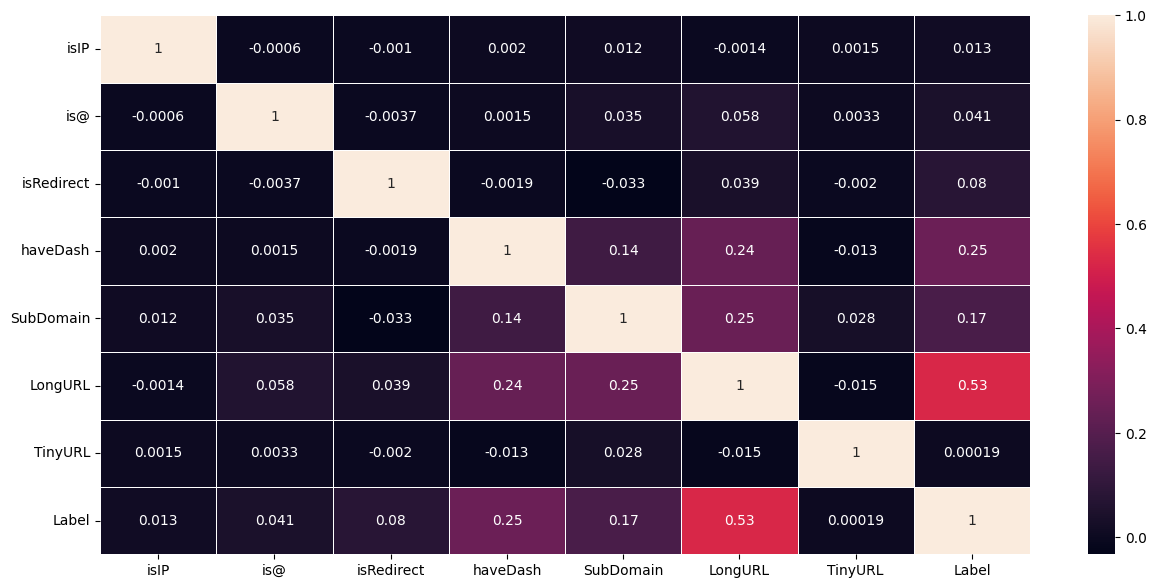

In [46]:
# Tạo biểu đồ HeatMap
plt.figure(figsize = (15, 7)) # Rộng: 15, Cao: 7
# Tạo HeatMap với thông số:
# Hiển thị giá trị tương quan trên từng ô của HeatMap.
# Điều chỉnh độ dày đường viền của các ô.
sns.heatmap(phishing_raw_df1.corr(),annot = True, linewidth = 0.5)

In [47]:
# Loại bỏ cột "Label" khỏi DataFrame và lưu phần còn lại vào biến X.
X = phishing_raw_df_x.drop(["Label"], axis = 1)

# Lưu trữ cột "Label" vào biến Y.
Y = phishing_raw_df_x["Label"]

# Chia tập dữ liệu làm 2 phần:
# X_train và y_train là dữ liệu huấn luyện, chiếm 80% của dữ liệu ban đầu.
# X_test  và y_test  là dữ liệu kiểm thử,   chiếm 20% của dữ liệu ban đầu.
# test_size = 0.2 chỉ định tỷ lệ dữ liệu được sử dụng cho kiểm thử (20%)
# random_state = 101: Đặt giá trị khởi tạo cho bộ sinh số ngẫu nhiên,
# giúp xác định cách chia dữ liệu một cách ngẫu nhiên nhưng vẫn đảm bảo tính tái lập.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 101)

In [48]:
# Tạo bộ phân loại cây quyết định (Decision Tree Classifier) trên dữ liệu huấn luyện.
dtc = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth = 5)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=100)

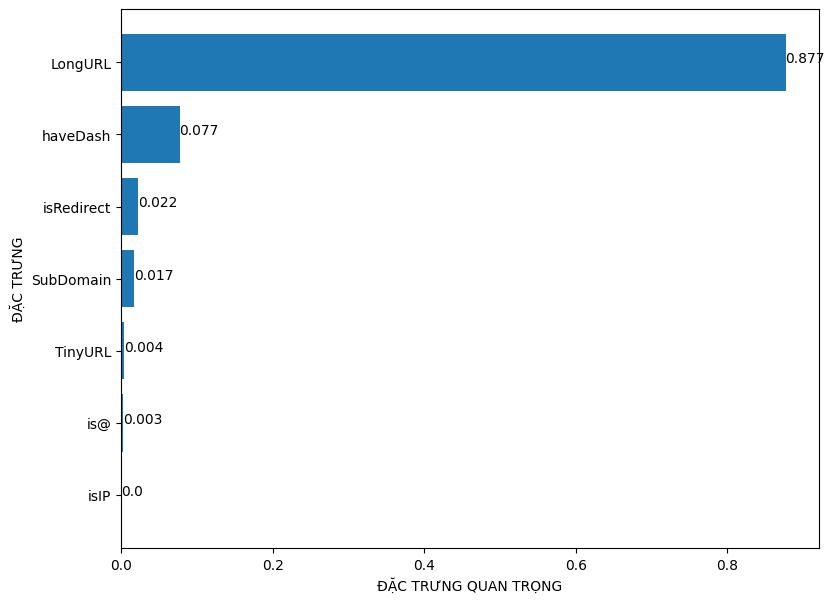

In [49]:
# Lấy tầm quan trọng của các đặc trưng từ mô hình cây quyết định đã được huấn luyện.
importances = dtc.feature_importances_

# Sắp xếp các đặc trưng theo tầm quan trọng giảm dần.
indices = np.argsort(importances)

plt.figure(figsize = (9, 7)) # Rộng: 9, Cao: 7

# Lấy số lượng đặc trưng trong tập huấn luyện.
n_features = X_train.shape[1]

# Tạo biểu đồ.
plt.barh(range(n_features), importances[indices], align = 'center')

# Đặt nhãn cho trục y bằng tên các đặc trưng được sắp xếp theo tầm quan trọng.
plt.yticks(np.arange(n_features), X_train.columns[indices])
for index, value in enumerate(importances[indices]):
    plt.text(value, index, str(round(value,3)))
plt.xlabel("ĐẶC TRƯNG QUAN TRỌNG")
plt.ylabel("ĐẶC TRƯNG")
plt.show()

In [50]:
phishing_raw_df_x.head()

,isIP,is@,isRedirect,haveDash,SubDomain,LongURL,TinyURL,Label
0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,1,0,1
2,0,0,0,0,0,1,0,1
3,0,0,0,0,1,0,0,0
4,0,0,0,0,1,1,0,1


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values, test_size = 0.3, random_state = 101)

## Model Development

### XGBoost

In [52]:
# Huấn luyện và đánh giá mô hình XGBoost trên dữ liệu đã được chia thành
# tập huấn luyện (X_train, y_train) và tập kiểm thử (X_test, y_test)
def XG_Boost_classifier():
    global XGB_model

    # Tạo đối tượng XGBoost
    XGB_model = XGBClassifier(random_state = 100)

    # HUẤN LUYỆN MÔ HÌNH
    # Ghi nhận thời gian bắt đầu huấn luyện.
    train_start = timeit.default_timer()
    # Huấn luyện mô hình XGBoost dựa trên tập huấn luyện và nhãn tương ứng.
    XGB_model.fit(X_train, y_train)
    # Tính toán thời gian huấn luyện mô hình.
    train_time = timeit.default_timer() - train_start

    # ĐƯA RA DỰ ĐOÁN TRÊN TẬP KIỂM TRA
    # Ghi nhận thời gian bắt đầu dự đoán.
    test_start = timeit.default_timer()
    # Sử dụng mô hình đã huấn luyện để đưa ra dự đoán trên tập kiểm tra.
    pred_XGB_test = XGB_model.predict(X_test)
    # Tính toán thời gian dự đoán trên tập kiểm tra.
    test_time = timeit.default_timer() - test_start

    # ĐƯA RA DƯ ĐOÁN TRÊN TẬP HUẤN LUYỆN
    pred_XGB_train = XGB_model.predict(X_train)

    # TÍNH HỆ SỐ KAPPA
    # (đánh giá độ chính xác của mô hình, đặc biệt khi dữ liệu không cân bằng)
    kappa_XGB = cohen_kappa_score(y_test, pred_XGB_test)

    print('\n--------------- XGBoost ---------------\n')
    print('BÁO CÁO PHÂN LOẠI:\n', classification_report(y_test, pred_XGB_test, target_names=['0','1']))

    # Tạo đối tượng biểu diễn ma trận nhầm lẫn.
    disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, pred_XGB_test), display_labels = ['0','1'])
    print('\nMA TRẬN NHẦM LẪN:\n',disp.plot())

    return (('XGBoost',accuracy_score(y_train, pred_XGB_train), accuracy_score(y_test, pred_XGB_test), kappa_XGB, train_time, test_time))

## CÂY QUYẾT ĐỊNH

In [53]:
# Huấn luyện và đánh giá mô hình CÂY QUYẾT ĐỊNH trên dữ liệu đã được chia thành
# tập huấn luyện (X_train, y_train) và tập kiểm thử (X_test, y_test)
def Decision_Tree_classifier():
    global DTC_model

    # Tạo đổi tượng CÂY QUYẾT ĐỊNH
    DTC_model = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth = 5)

    # HUẤN LUYỆN MÔ HÌNH
    # Ghi nhận thời gian bắt đầu huấn luyện.
    train_start = timeit.default_timer()
    # Huấn luyện mô hình CÂY QUYẾT ĐỊNH dựa trên tập huấn luyện và nhãn tương ứng.
    DTC_model.fit(X_train, y_train)
    # Tính toán thời gian huấn luyện mô hình.
    train_time = timeit.default_timer() - train_start

    # ĐƯA RA DỰ ĐOÁN TRÊN TẬP KIỂM TRA
    # Ghi nhận thời gian bắt đầu dự đoán.
    test_start = timeit.default_timer()
    # Sử dụng mô hình đã huấn luyện để đưa ra dự đoán trên tập kiểm tra.
    pred_dtc_test = DTC_model.predict(X_test)
    # Tính toán thời gian dự đoán trên tập kiểm tra.
    test_time = timeit.default_timer() - test_start

    # ĐƯA RA DƯ ĐOÁN TRÊN TẬP HUẤN LUYỆN
    pred_dtc_train = DTC_model.predict(X_train)

    # TÍNH HỆ SỐ KAPPA
    # (đánh giá độ chính xác của mô hình, đặc biệt khi dữ liệu không cân bằng)
    kappa_dtc = cohen_kappa_score(y_test, pred_dtc_test)

    print('\n--------------- CÂY QUYẾT ĐỊNH ---------------\n')
    print('BÁO CÁO PHÂN LOẠI:\n', classification_report(y_test, pred_dtc_test, target_names=['0','1']))

    # Tạo đối tượng biểu diễn ma trận nhầm lẫn.
    disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, pred_dtc_test),display_labels = ['0','1'])
    print('\nMA TRẬN NHẦM LẪN:\n',disp.plot())

    return (('CÂY QUYẾT ĐỊNH',accuracy_score(y_train,pred_dtc_train),accuracy_score(y_test,pred_dtc_test), kappa_dtc, train_time,test_time))

## MẠNG NƠRON NHÂN TẠO

In [54]:
# Huấn luyện và đánh giá mô hình MẠNG NƠRON NHÂN TẠO trên dữ liệu đã được chia thành
# tập huấn luyện (X_train, y_train) và tập kiểm thử (X_test, y_test)
def Neural_Network_classifier():
    global MLP_model

    # Tạo đổi tượng MẠNG NƠRON NHÂN TẠO (3 lớp ẩn, mỗi lớp chứa 12 nơron)
    MLP_model = MLPClassifier(hidden_layer_sizes = (12, 12, 12), activation = 'relu', solver = 'adam', max_iter = 500)

    # HUẤN LUYỆN MÔ HÌNH
    # Ghi nhận thời gian bắt đầu huấn luyện.
    train_start = timeit.default_timer()
    # Huấn luyện mô hình CÂY QUYẾT ĐỊNH dựa trên tập huấn luyện và nhãn tương ứng.
    MLP_model.fit(X_train,y_train)
    # Tính toán thời gian huấn luyện mô hình.
    train_time = timeit.default_timer() - train_start

    # ĐƯA RA DỰ ĐOÁN TRÊN TẬP KIỂM TRA
    # Ghi nhận thời gian bắt đầu dự đoán.
    test_start = timeit.default_timer()
    # Sử dụng mô hình đã huấn luyện để đưa ra dự đoán trên tập kiểm tra.
    pred_NN_test = MLP_model.predict(X_test)
    # Tính toán thời gian dự đoán trên tập kiểm tra.
    test_time = timeit.default_timer() - test_start

    # ĐƯA RA DƯ ĐOÁN TRÊN TẬP HUẤN LUYỆN
    pred_NN_train = MLP_model.predict(X_train)

    # TÍNH HỆ SỐ KAPPA
    # (đánh giá độ chính xác của mô hình, đặc biệt khi dữ liệu không cân bằng)
    kappa_NN = cohen_kappa_score(y_test, pred_NN_test)

    print('\n--------------- MẠNG NƠRON NHÂN TẠO ---------------\n')
    print('BÁO CÁO PHÂN LOẠI:\n', classification_report(y_test, pred_NN_test, target_names=['0','1']))

    # Tạo đối tượng biểu diễn ma trận nhầm lẫn.
    disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, pred_NN_test), display_labels = ['0','1'])
    print('\nMA TRẬN NHẦM LẪN:\n',disp.plot())


    return (('MẠNG NƠRON NHÂN TẠO', accuracy_score(y_train, pred_NN_train), accuracy_score(y_test, pred_NN_test), kappa_NN, train_time,test_time))

# SUPPORT VECTOR MACHINE

In [55]:
# Huấn luyện và đánh giá mô hình SVM trên dữ liệu đã được chia thành
# tập huấn luyện (X_train, y_train) và tập kiểm thử (X_test, y_test)
def Svm_classifier():
    global SVM_model

    # Tạo một đối tượng SVC (Support Vector Classifier) (poly: kernel đa thức, bậc 9)
    SVM_model = SVC(kernel = 'poly', degree = 9, random_state = 12)

    # HUẤN LUYỆN MÔ HÌNH
    # Ghi nhận thời gian bắt đầu huấn luyện.
    train_start = timeit.default_timer()
    # Huấn luyện mô hình SVM dựa trên tập huấn luyện và nhãn tương ứng.
    SVM_model.fit(X_train, y_train)
    # Tính toán thời gian huấn luyện mô hình.
    train_time = timeit.default_timer() - train_start

    # ĐƯA RA DỰ ĐOÁN TRÊN TẬP KIỂM TRA
    # Ghi nhận thời gian bắt đầu dự đoán.
    test_start = timeit.default_timer()
    # Sử dụng mô hình đã huấn luyện để đưa ra dự đoán trên tập kiểm tra.
    pred_svm_test = SVM_model.predict(X_test)
    # Tính toán thời gian dự đoán trên tập kiểm tra.
    test_time = timeit.default_timer() - test_start

    # ĐƯA RA DƯ ĐOÁN TRÊN TẬP HUẤN LUYỆN
    pred_svm_train = SVM_model.predict(X_train)

    # TÍNH HỆ SỐ KAPPA
    # (đánh giá độ chính xác của mô hình, đặc biệt khi dữ liệu không cân bằng)
    kappa_svm = cohen_kappa_score(y_test, pred_svm_test)

    print('\n--------------- SUPPORT VECTOR MACHINE ---------------\n')
    print('BÁO CÁO PHÂN LOẠI:\n', classification_report(y_test, pred_svm_test, target_names=['0','1']))

    # Tạo đối tượng biểu diễn ma trận nhầm lẫn.
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_svm_test),display_labels=['0','1'])
    print('\nMA TRẬN NHẦM LẪN:\n',disp.plot())


    return (('SUPPORT VECTOR MACHINE',accuracy_score(y_train,pred_svm_train),accuracy_score(y_test,pred_svm_test), kappa_svm, train_time,test_time))

# NAIVE BAYES

In [56]:
# Huấn luyện và đánh giá mô hình NAIVE BAYES trên dữ liệu đã được chia thành
# tập huấn luyện (X_train, y_train) và tập kiểm thử (X_test, y_test)
def Naive_Bayes_classifier():
    global NBC_model

    # Tạo một đối tượng BernoulliNB (Naive Bayes dạng Bernoulli)
    NBC_model = BernoulliNB()

    # HUẤN LUYỆN MÔ HÌNH
    # Ghi nhận thời gian bắt đầu huấn luyện.
    train_start = timeit.default_timer()
    # Huấn luyện mô hình NAIVE BAYES dựa trên tập huấn luyện và nhãn tương ứng.
    NBC_model.fit(X_train, y_train)
    # Tính toán thời gian huấn luyện mô hình.
    train_time = timeit.default_timer() - train_start

    # ĐƯA RA DỰ ĐOÁN TRÊN TẬP KIỂM TRA
    # Ghi nhận thời gian bắt đầu dự đoán.
    test_start = timeit.default_timer()
    # Sử dụng mô hình đã huấn luyện để đưa ra dự đoán trên tập kiểm tra.
    pred_nb_test = NBC_model.predict(X_test)
    # Tính toán thời gian dự đoán trên tập kiểm tra.
    test_time = timeit.default_timer() - test_start

    # ĐƯA RA DƯ ĐOÁN TRÊN TẬP HUẤN LUYỆN
    pred_nb_train = NBC_model.predict(X_train)

    # TÍNH HỆ SỐ KAPPA
    # (đánh giá độ chính xác của mô hình, đặc biệt khi dữ liệu không cân bằng)
    kappa_nb = cohen_kappa_score(y_test, pred_nb_test)

    print('\n--------------- NAIVE BAYES ---------------\n')
    print('BÁO CÁO PHÂN LOẠI:\n', classification_report(y_test, pred_nb_test, target_names=['0','1']))

    # Tạo đối tượng biểu diễn ma trận nhầm lẫn.
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_nb_test),display_labels=['0','1'])
    print('\nMA TRẬN NHẦM LẪN:\n',disp.plot())

    return (('NAIVE BAYES',accuracy_score(y_train,pred_nb_train),accuracy_score(y_test,pred_nb_test),kappa_nb, train_time,test_time))

# HỒI QUY LOGISTIC

In [57]:
# Huấn luyện và đánh giá mô hình HỒI QUY LOGISTIC trên dữ liệu đã được chia thành
# tập huấn luyện (X_train, y_train) và tập kiểm thử (X_test, y_test)
def Logistic_Regression_classifier():
    global LOG_model

    # Tạo một đối tượng LogisticRegression
    LOG_model = LogisticRegression(random_state = 100)

    # HUẤN LUYỆN MÔ HÌNH
    # Ghi nhận thời gian bắt đầu huấn luyện.
    train_start = timeit.default_timer()
    # Huấn luyện mô hình HỒI QUY LOGISTIC dựa trên tập huấn luyện và nhãn tương ứng.
    LOG_model.fit(X_train, y_train)
    # Tính toán thời gian huấn luyện mô hình.
    train_time = timeit.default_timer() - train_start

    # ĐƯA RA DỰ ĐOÁN TRÊN TẬP KIỂM TRA
    # Ghi nhận thời gian bắt đầu dự đoán.
    test_start = timeit.default_timer()
    # Sử dụng mô hình đã huấn luyện để đưa ra dự đoán trên tập kiểm tra.
    pred_logreg_test = LOG_model.predict(X_test)
    # Tính toán thời gian dự đoán trên tập kiểm tra.
    test_time = timeit.default_timer() - test_start

    # ĐƯA RA DƯ ĐOÁN TRÊN TẬP HUẤN LUYỆN
    pred_logreg_train = LOG_model.predict(X_train)

    # TÍNH HỆ SỐ KAPPA
    # (đánh giá độ chính xác của mô hình, đặc biệt khi dữ liệu không cân bằng)
    kappa_lg =  cohen_kappa_score(y_test, pred_logreg_test)

    print('\n--------------- HỒI QUY LOGISTIC ---------------\n')
    print('BÁO CÁO PHÂN LOẠI:\n', classification_report(y_test, pred_logreg_test, target_names=['0','1']))

    # Tạo đối tượng biểu diễn ma trận nhầm lẫn.
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_logreg_test),display_labels=['0','1'])
    print('\nMA TRẬN NHẦM LẪN::\n', disp.plot())

    return (('HỒI QUY LOGISTIC', accuracy_score(y_train, pred_logreg_train), accuracy_score(y_test,pred_logreg_test),kappa_lg, train_time,test_time))

# RANDOM FOREST

In [58]:
# Huấn luyện và đánh giá mô hình RANDOM FOREST trên dữ liệu đã được chia thành
# tập huấn luyện (X_train, y_train) và tập kiểm thử (X_test, y_test)
def Random_Forest_classifier():
    global RFC_model

    # Tạo một đối tượng RandomForestClassifier
    RFC_model = RandomForestClassifier(criterion='entropy',random_state=100)

    # HUẤN LUYỆN MÔ HÌNH
    # Ghi nhận thời gian bắt đầu huấn luyện.
    train_start = timeit.default_timer()
    # Huấn luyện mô hình RANDOM FOREST dựa trên tập huấn luyện và nhãn tương ứng.
    RFC_model.fit(X_train, y_train)
    # Tính toán thời gian huấn luyện mô hình.
    train_time = timeit.default_timer() - train_start

    # ĐƯA RA DỰ ĐOÁN TRÊN TẬP KIỂM TRA
    # Ghi nhận thời gian bắt đầu dự đoán.
    test_start = timeit.default_timer()
    # Sử dụng mô hình đã huấn luyện để đưa ra dự đoán trên tập kiểm tra.
    pred_RF_test = RFC_model.predict(X_test)
    # Tính toán thời gian dự đoán trên tập kiểm tra.
    test_time = timeit.default_timer() - test_start

    # ĐƯA RA DƯ ĐOÁN TRÊN TẬP HUẤN LUYỆN
    pred_RF_train = RFC_model.predict(X_train)

    # TÍNH HỆ SỐ KAPPA
    # (đánh giá độ chính xác của mô hình, đặc biệt khi dữ liệu không cân bằng)
    kappa_rf = cohen_kappa_score(y_test, pred_RF_test)

    print('\n--------------- RANDOM FOREST ---------------\n')
    print('BÁO CÁO PHÂN LOẠI:\n', classification_report(y_test, pred_RF_test, target_names=['0','1']))

    # Tạo đối tượng biểu diễn ma trận nhầm lẫn.
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_RF_test),display_labels=['0','1'])
    print('\nMA TRẬN NHẦM LẪN:\n',disp.plot())

    return (('RANDOM FOREST',accuracy_score(y_train,pred_RF_train),accuracy_score(y_test,pred_RF_test),kappa_rf, train_time, test_time))

## Evaluation Metrics

In [59]:
# Vẽ đồ thị ROC (Receiver Operating Characteristic) cho nhiều mô hình khác nhau.
def Roc_curves():
    # Tạo một figure mới để bắt đầu vẽ đồ thị ROC.
    plt.figure()

    # Tạo danh sách models chứa thông tin các mô hình cần vẽ ROC curve.
    models = [
    {
        'label': 'HỒI QUY LOGISTIC',
        'model': LogisticRegression(random_state = 100),
    },
    {
        'label': 'SUPPORT VECTOR MACHINE',
        'model': SVC(kernel = 'linear', C = 1.0, random_state = 100,probability = True),
    },
    {
        'label': 'NAIVE BAYES',
        'model': BernoulliNB(),
    },
    {
        'label': 'CÂY QUYẾT ĐỊNH',
        'model': DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth = 5),
    },
    {
        'label': 'RANDOM FOREST',
        'model': RandomForestClassifier(criterion = 'entropy',random_state = 100)
    },
    {
        'label': 'XGBoost',
        'model': XGBClassifier(random_state=100),
    },
    {
        'label': 'MẠNG NƠRON NHÂN TẠO',
        'model': MLPClassifier(hidden_layer_sizes = (12, 12, 12), activation = 'relu', solver = 'adam', max_iter = 500)
    }
    ]

    for m in models:
        model = m['model']              # Duyệt qua từng mô hình
        model.fit(X_train, y_train)     # Huấn luyện mô hình trên tập huấn luyện.
        y_pred = model.predict(X_test)  # Dự đoán nhãn trên tập kiểm tra.

        # Tính tỷ lệ dương tính giả (FPR) và tỷ lệ đúng dương tính (TPR) để tạo đường ROC.
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])

        # Tính diện tích dưới đường ROC (AUC), đại diện cho hiệu suất tổng thể của mô hình.
        auc = metrics.roc_auc_score(y_test, model.predict(X_test))

        # Vẽ đường ROC cho mô hình hiện tại và thêm nhãn bao gồm tên mô hình và giá trị AUC.
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

    # TÙY CHỈNH ĐỒ THỊ
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [60]:
# Gọi và tổng hợp kết quả của các mô hình học máy:
def call_ml_models():

    # Khởi tạo các danh sách để lưu trữ các giá trị đánh giá và thời gian của từng mô hình.
    kappa_list = []   # Lưu trữ hệ số Kappa của các mô hình.
    ML_Model   = []   # Lưu trữ tên các mô hình.
    acc_train  = []   # Lưu trữ độ chính xác trên tập huấn luyện.
    acc_test   = []   # Lưu trữ độ chính xác trên tập kiểm tra.
    train_time = []   # Lưu trữ thời gian huấn luyện của các mô hình.
    test_time  = []   # Lưu trữ thời gian dự đoán của các mô hình.
    model_list = [Logistic_Regression_classifier, Naive_Bayes_classifier,
                  Svm_classifier, Decision_Tree_classifier,Random_Forest_classifier,
                  XG_Boost_classifier,Neural_Network_classifier]

    # Lặp qua các mô hình và thu thập kết quả.
    for model in model_list:
        res = model()
        ML_Model.append(res[0])
        acc_train.append(res[1])
        acc_test.append(res[2])
        kappa_list.append(res[3])
        train_time.append(res[4])
        test_time.append(res[5])

    # Hiển thị đường cong ROC của tất cả các mô hình.
    Roc_curves()

    return ML_Model,acc_train,acc_test,kappa_list,train_time,test_time


--------------- HỒI QUY LOGISTIC ---------------

BÁO CÁO PHÂN LOẠI:
               precision    recall  f1-score   support

           0       0.72      0.85      0.78      9334
           1       0.82      0.67      0.74      9281

    accuracy                           0.76     18615
   macro avg       0.77      0.76      0.76     18615
weighted avg       0.77      0.76      0.76     18615


MA TRẬN NHẦM LẪN::

--------------- NAIVE BAYES ---------------

BÁO CÁO PHÂN LOẠI:
               precision    recall  f1-score   support

           0       0.72      0.85      0.78      9334
           1       0.82      0.67      0.74      9281

    accuracy                           0.76     18615
   macro avg       0.77      0.76      0.76     18615
weighted avg       0.77      0.76      0.76     18615


MA TRẬN NHẦM LẪN:

--------------- SUPPORT VECTOR MACHINE ---------------

BÁO CÁO PHÂN LOẠI:
               precision    recall  f1-score   support

           0       0.72      0.85     

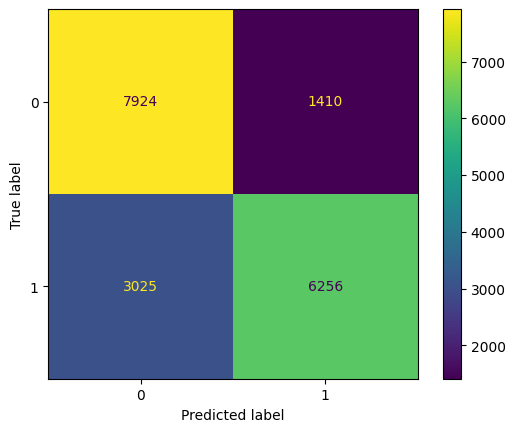

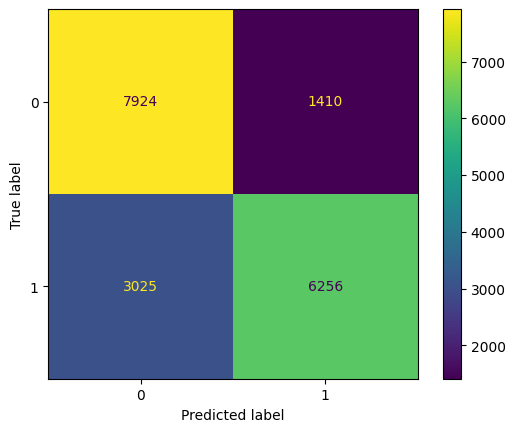

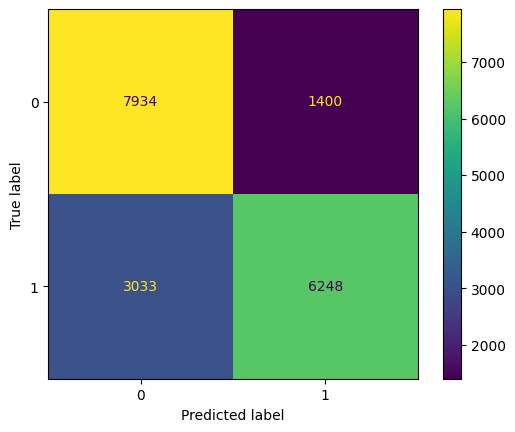

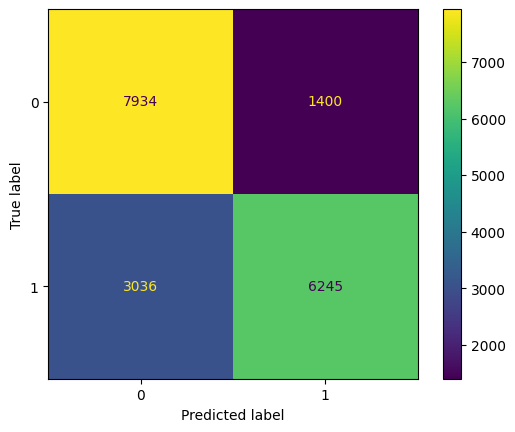

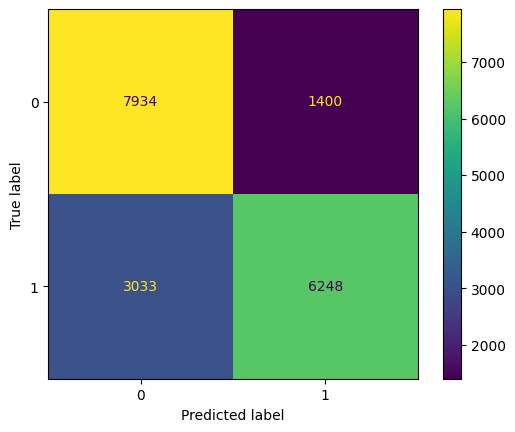

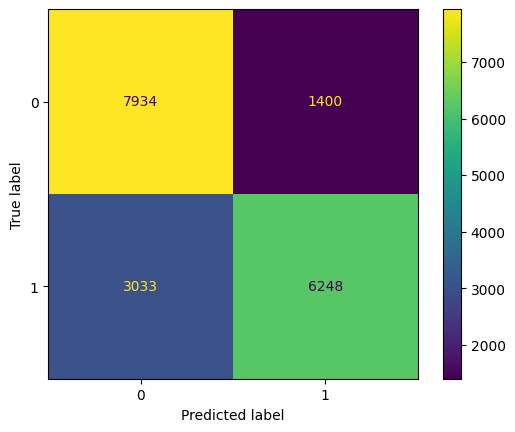

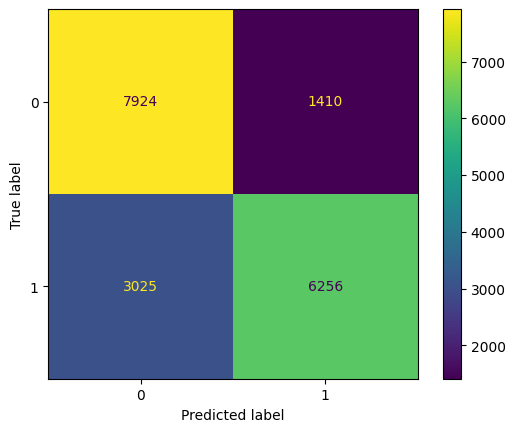

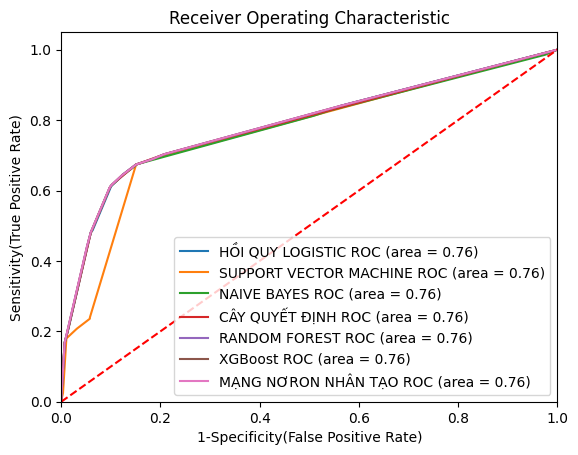

,MÔ HÌNH,ĐỘ CHÍNH XÁC TRÊN TẬP HUẤN LUYỆN,ĐỘ CHÍNH XÁC TRÊN TẬP KIỂM TRA,HỆ SỐ KAPPA,THỜI GIAN HUẤN LUYỆN,THỜI GIAN DỰ ĐOÁN
0,HỒI QUY LOGISTIC,0.760147,0.761751,0.523263,0.190688,0.000630
1,NAIVE BAYES,0.760147,0.761751,0.523263,0.015331,0.002154
2,SUPPORT VECTOR MACHINE,0.760239,0.761859,0.523476,44.547034,6.965989
3,CÂY QUYẾT ĐỊNH,0.760193,0.761698,0.523153,0.011285,0.001157
4,RANDOM FOREST,0.760239,0.761859,0.523476,0.767244,0.113009
5,XGBoost,0.760239,0.761859,0.523476,0.208775,0.022459
6,MẠNG NƠRON NHÂN TẠO,0.760147,0.761751,0.523263,2.209353,0.018519


In [61]:
# Gọi hàm call_ml_models() để lấy thông tin về hiệu suất của tất cả các mô hình.
ML_Model,acc_train,acc_test,kappa_list,train_time,test_time = call_ml_models()

# Tạo một DataFrame với các cột ứng với thông tin hiệu suất và thời gian của mỗi mô hình.
results = pd.DataFrame({'MÔ HÌNH': ML_Model, 'ĐỘ CHÍNH XÁC TRÊN TẬP HUẤN LUYỆN': acc_train,
                        'ĐỘ CHÍNH XÁC TRÊN TẬP KIỂM TRA': acc_test, 'HỆ SỐ KAPPA': kappa_list,
                        'THỜI GIAN HUẤN LUYỆN': train_time, 'THỜI GIAN DỰ ĐOÁN': test_time})
results

## HYPERPARAMETER TURNING (ĐIỀU CHỈNH SIÊU THAM SỐ)

In [62]:
# Thiết lập không gian tham số và các chỉ số đánh giá cho việc
# điều chỉnh siêu tham số của mô hình XGBoost
param_grid = [
  {
    'n_estimators': [200, 250],
    'max_depth': [5,6]
  }
]

scoring = {'AUC':'roc_auc', 'ĐỘ CHÍNH XÁC':make_scorer(accuracy_score)}

In [63]:
# Tìm kiếm siêu tham số tối ưu cho mô hình XGBoost

# Khởi tạo đối tượng GridSearchCV để thực hiện tìm kiếm lưới tham số.
XGB_grid = GridSearchCV(XGB_model, param_grid = param_grid, cv = 5,scoring = scoring, refit = 'AUC', verbose = 1, n_jobs = -1)

# Huấn luyện mô hình với Grid Search.
XGB_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=100, ...),
             n_jobs=-1,
             param_grid=[{'max_depth': [5, 6], 'n_estimators': [200, 250]}],
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'ĐỘ CHÍNH XÁC': make_scorer(accuracy_score)},
             verbose=1)

In [64]:
# Huấn luyện và đánh giá mô hình XGBoost với các siêu tham số tối ưu đã được tìm kiếm bằng Grid Search.

# Lấy mô hình XGBoost tốt nhất từ kết quả của quá trình tìm kiếm siêu tham số.
XGB_model_best = XGB_grid.best_estimator_

# Huấn luyện lại mô hình với tham số tối ưu trên tập huấn luyện để đảm bảo hiệu suất tốt nhất.
XGB_model_best.fit(X_train, y_train)

# Đưa ra dự đoán trên tập kiểm tra.
pred_RF_test = XGB_model_best.predict(X_test)
# Đưa ra dự đoán trên tập huấn luyện.
pred_RF_train = XGB_model_best.predict(X_train)

# Tính hệ số KAPPA giữa dự đoán và nhãn thực tế trên tập dữ liệu kiểm tra.
kappa_rf = cohen_kappa_score(y_test, pred_RF_test)
# Tính độ chính xác của mô hình trên toàn bộ tập dữ liệu huấn luyện.
train_acc = accuracy_score(y_train,pred_RF_train)
# Tính độ chính xác của mô hình trên tập dữ liệu kiểm tra.
test_acc = accuracy_score(y_test,pred_RF_test)

print('HỆ SỐ KAPPA: ',kappa_rf)
print('ĐỘ CHÍNH XÁC TRÊN TẬP HUẤN LUYỆN: ', train_acc)
print('ĐỘ CHÍNH XÁC TRÊN TẬP KIỂM TRA: ', test_acc)

HỆ SỐ KAPPA:  0.5234755286242555
ĐỘ CHÍNH XÁC TRÊN TẬP HUẤN LUYỆN:  0.7602394382410499
ĐỘ CHÍNH XÁC TRÊN TẬP KIỂM TRA:  0.7618587160891754


## LƯU LẠI MÔ HÌNH XGBOOST ĐÃ HUẤN LUYỆN

In [65]:
def save_model(model):
    with open('PHISHING_CLASSIFIER.pkl', 'wb') as f:
        pickle.dump(model, f, -1)
        f.close()
save_model(XGB_model_best)

## TIẾN HÀNH PHÂN LOẠI BĂNG MÔ HÌNH ĐÃ LƯU

In [66]:
import pandas as pd
import numpy as np
import sys
import re
from urllib.parse import urlparse,urlencode
from bs4 import BeautifulSoup
from datetime import datetime
import ipaddress
import whois
import urllib
import urllib.request
import tldextract
import pickle

class FeatureExtract:

    def __init__(self):
        pass

    # # Phương thức kiểm tra xem có địa chỉ IP tồn tại trong URL không.
    # Nếu có trả về 1 (lừa đảo), không có trả về 0 (hợp pháp).
    def isIP(self,url):
        try:
            ipaddress.ip_address(url)
            ip = 1
        except:
            ip = 0
        return ip

    # Phương thức kiểm tra tính hợp lệ của URL.
    # Nếu tuổi của tên miền < 6 tháng, trả về 1 (lừa đảo), ngược lại trả về 0 (hợp pháp).
    def isValid(self,domain_name):
        creation_date = domain_name.creation_date
        expiration_date = domain_name.expiration_date
        if (isinstance(creation_date,str) or isinstance(expiration_date,str)):
            try:
                creation_date = datetime.strptime(creation_date,'%Y-%m-%d')
                expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
            except:
                  return 1
        if ((expiration_date is None) or (creation_date is None)):
            return 1
        elif ((type(expiration_date) is list) or (type(creation_date) is list)):
            return 1
        else:
            ageofdomain = abs((expiration_date - creation_date).days)
            if ((ageofdomain/30) < 6):
                age = 1
            else:
                age = 0
        return age

    # Kiểm tra xem URL đã hết hạn hay chưa.
    # Nếu tên miền đã hết hạn, trả về 1 (lừa đảo), ngược lại trả về 0 (hợp pháp)
    def domain_reg_len(self,domain_name):
        print('hello')
        expiration_date = domain_name.expiration_date
        if isinstance(expiration_date,str):
            try:
                expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
            except:
                return 1
        if (expiration_date is None):
            return 1
        elif (type(expiration_date) is list):
            return 1
        else:
            today = datetime.now()
            end = abs((expiration_date - today).days)
            if ((end/30) < 6):
                end = 0
            else:
                end = 1
        return end

    # Kiểm tra xem URL có chứa '@' hay không.
    # Nếu có '@' trả về 1 (lừa đảo), ngược lại trả về 0 (hợp pháp)
    def isat(self,url):
        if "@" in url:
            return 1
        else:
            return 0

    # Kiểm tra xem URL có chứa '//' liền kề
    # trong ngữ cảnh của 'http://' hoặc 'https://' không
    # Nếu có trả về 1 (lừa đảo), ngược lại trả về 0 (hợp pháp)
    def isRedirect(self,url):
        pos = url.rfind('//')
        if pos > 6:
            if pos > 7:
                return 1
            else:
                return 0
        else:
            return 0

    # Kiểm tra xem có chứa '-' trong phần netloc của URL không.
    # Nếu có trả vê 1 (lừa đảo), nếu không trả về 0 (hợp pháp).
    def haveDash(self,url):
        if '-' in urlparse(url).netloc:
            return 1
        else:
            return 0

    # Kiếm tra xem URL có chưa nhiều hơn một tên miền phụ hay không.
    # Nếu số lượng tên miền là 1, trả về 0 (hợp pháp), ngược lại trả về 1 (lừa đảo)
    def no_sub_domain(self,url):
        url = str(url)
        url = url.replace("www.","")
        url = url.replace("."+tldextract.extract(url).suffix,"")
        count = url.count(".")
        if count==1:
            return 0
        else:
            return 1

    # Kiểm tra xem có chứa 'http' trong phần netloc của URL hay không.
    # Nếu có trả về 1 (lừa đảo), nếu không trả về 0 (hợp pháp)
    def httpDomain(self,url):
        domain = urlparse(url).netloc
        if 'http' in domain:
            return 1
        else:
            return 0

    # Kiểm tra độ dài của URL.
    # Nếu độ dài < 54 kí tự , trả về 0 (hợp pháp), ngược lại trả về 1 (lừa đảo)
    def LongURL(self,url):
        if len(url) < 54:
            return 0
        else:
            return 1

    # Kiểm tra xem URL có thuộc về các dịch vụ rút gọn URL hay không.
    # Nếu có trả về 1 (lừa đảo), ngược lại trả về 0 (hợp pháp).
    def tinyURL(self,url):
        shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"
        match=re.search(shortening_services,url)
        if match:
            return 1
        else:
            return 0
# Chứa các phương thức để dự đoán xem URL có phải là trang web lừa đảo hay không.
class PredictURL(FeatureExtract):
    def __init__(self):
        pass

    # Nhận một URL làm đối số và trả về dự đoán về tính độc hại của URL đó
    # dựa trên các đặc trưng được trích xuất.
    def predict(self,url):
        print("hi")
        feature = []
        dns = 0

        feature.append(self.isIP(url))
        feature.append(self.isat(url))
        feature.append(self.isRedirect(url))
        feature.append(self.haveDash(url))
        feature.append(self.no_sub_domain(url))
        feature.append(self.LongURL(url))
        feature.append(self.tinyURL(url))

        return self.classify(np.array(feature).reshape((1,-1)))

    def __getstate__(self):
        state = self.__dict__.copy()
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)

    # Tải mô hình đã lưu, sử dụng nó để dự đoán trên các đặc trưng.
    def classify(self,features):
        pick_file = open('/content/PHISHING_CLASSIFIER.pkl', 'rb')
        Pickled_sample_Model = pickle.load(pick_file)
        pick_file.close()

        result = Pickled_sample_Model.predict(features)
        if result == 0:
            return "ĐÂY CÓ THỂ LÀ TRANG WEB HỢP PHÁP. (LEGITIMATE)"
        else:
            return "ĐÂY CÓ THỂ LÀ TRANG WEB LỪA ĐẢO. (PHISHING)"

def main():
    pass

if __name__ == "__main__":
    main()

In [67]:
classification = PredictURL()

In [72]:
%%time
classification.predict('https://www.google.com')
# classification.predict('https://att-105877.weeblysite.com/')

hi
CPU times: user 10.4 ms, sys: 0 ns, total: 10.4 ms
Wall time: 12.3 ms


'ĐÂY CÓ THỂ LÀ TRANG WEB HỢP PHÁP. (LEGITIMATE)'